In [42]:
import tensorflow
import keras
import cv2
import dlib
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import traceback
from sklearn import preprocessing 
from imutils import face_utils
from tensorflow.keras.callbacks import *

%matplotlib inline

In [43]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import scipy.misc
import dlib
import cv2
from sklearn import preprocessing
from imutils import face_utils
import numpy as np
from keras.optimizers import *

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy.random import seed
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

num_classes = 7 #'Angry','Disgust', 'Fear', 'Happy', 'Neutral', Sad', 'Surprise'
batch_size = 64
epochs = 300
fit = True
seed(8)

# --------------------------------------------------------------------
# Data preperation from csv file
def prepare_data(fileName):
	X, Y = [], []
	x_train, y_train, x_test, y_test = [], [], [], []
	with open(fileName) as f:
		content = f.readlines()
		lines = np.array(content)
		num_of_instances = lines.size
		
		for i in range(1,num_of_instances):   	
			emotion, distances = lines[i].split(",")
			distances = distances.strip() 
			val = distances.split(" ")
			val = np.array(val)
			val = val.astype(np.float)

			emotion = keras.utils.to_categorical(emotion, num_classes)

			X.append(val)
			Y.append(emotion)
				
		x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=4)

		print ("********Training set size: ", str(len(x_train)))

		x_train = np.array(x_train)
		y_train = np.array(y_train)
		
		
		minmax = preprocessing.MinMaxScaler()
		x_train = minmax.fit_transform(x_train)
		
		x_test = np.array(x_test)
		y_test = np.array(y_test)

		# Normalization of the testing data   
		minmax = preprocessing.MinMaxScaler()
		x_test = minmax.fit_transform(x_test)

		return x_train, y_train, x_test, y_test


In [45]:
learning_rate_twist = ReduceLROnPlateau(monitor="val_loss",
                                       factor=0.1,
                                       patience=10,
                                       verbose=1,
                                       min_delta=0.00001,
                                       min_lr=1e-9)
stopping = EarlyStopping(monitor="val_loss",
                         min_delta=0.00001,
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )
callback_items = [stopping,learning_rate_twist]

********Training set size:  741
Training set size:  741
Test set size:  365
Epoch 1/250
12/12 [==============================] - 1s 49ms/step - loss: 2.3099 - accuracy: 0.1584 - val_loss: 1.6327 - val_accuracy: 0.5836
Epoch 2/250
12/12 [==============================] - 0s 17ms/step - loss: 1.7185 - accuracy: 0.5664 - val_loss: 1.4746 - val_accuracy: 0.5836
Epoch 3/250
12/12 [==============================] - 0s 18ms/step - loss: 1.5414 - accuracy: 0.5533 - val_loss: 1.3754 - val_accuracy: 0.5863
Epoch 4/250
12/12 [==============================] - 0s 19ms/step - loss: 1.4383 - accuracy: 0.5587 - val_loss: 1.2910 - val_accuracy: 0.6192
Epoch 5/250
12/12 [==============================] - 0s 19ms/step - loss: 1.3457 - accuracy: 0.5860 - val_loss: 1.2181 - val_accuracy: 0.6329
Epoch 6/250
12/12 [==============================] - 0s 18ms/step - loss: 1.3009 - accuracy: 0.5964 - val_loss: 1.1712 - val_accuracy: 0.6548
Epoch 7/250
12/12 [==============================] - 0s 18ms/step - loss

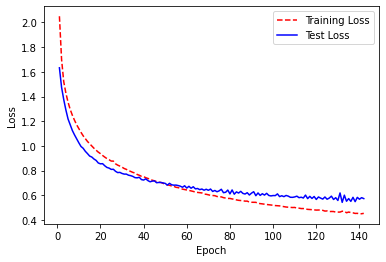

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


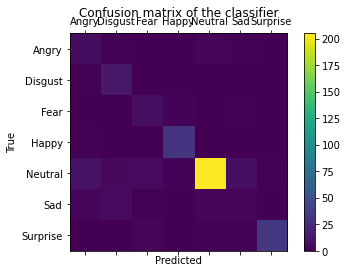

12/12 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.8274

testing accuracy: 82.74%
24/24 [==============================] - 0s 4ms/step - loss: 0.4699 - accuracy: 0.8340

training accuracy: 83.40%


In [46]:
epochs = 250
x_train, y_train, x_test, y_test = prepare_data("/content/drive/My Drive/491/data/JAFFE_CK.csv")
# print(x_train.shape)
# print(x_train)
# print(y_train.shape)
# print(y_train)
print ("Training set size: ", str(len(x_train)))
print ("Test set size: ", str(len(x_test)))
# --------------------------------------------------------------------
# Construct the NN structure
model = Sequential()
#1st layer
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Dense(128))


model.add(Dense(num_classes, activation='softmax'))

# compile the model
opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, # Features
                      y_train, # Target
                      epochs=epochs, # Number of epochs
                      verbose=1, # No output
                      batch_size=batch_size, # Number of observations per batch
                      validation_data=(x_test, y_test),
                      callbacks=callback_items)
# --------------------------------------------------------------------
# Visualize the training and test loss through epochs

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

y_pred = model.predict_classes(x_test)
y_true = [0] * len(y_pred)

for i in range(0, len(y_test)):
	max_index = np.argmax(y_test[i])
	y_true[i] = max_index

# --------------------------------------------------------------------
# Print wrong classifications 

#for i in range(len(y_pred)):
#	if(y_pred[i] != y_true[i]):
#		print(str(i) + ' --> Predicted: ' +  str(y_pred[i]) + " Expected: " + str(y_true[i]))

# --------------------------------------------------------------------
# Draw the confusion matrix 
cm = confusion_matrix(y_pred, y_true, labels=range(num_classes))

labels = ['Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --------------------------------------------------------------------
# Evaluate the model on the test set
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % ("testing "+model.metrics_names[1], scores[1]*100))

scores2 = model.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % ("training "+model.metrics_names[1], scores2[1]*100))
# --------------------------------------------------------------------
# Save the model and the weights 
#model_json = model.to_json()
#with open("/content/drive/My Drive/491/facial/modeltest.json", "w+") as json_file:
#    json_file.write(model_json)
#model.save_weights("/content/drive/My Drive/491/facial/modeltest.h5")
#print("Saved model to disk")

In [47]:
model.save("/content/drive/My Drive/491/facial/mweights.h5")
modelJsonfile = model.to_json()
with open("/content/drive/My Drive/491/facial/mstruc.json","w+") as jfile:
  jfile.write(modelJsonfile)

In [48]:
os.chdir("/content/drive/My Drive/491/facial")

In [49]:
!ls

CNBC.txt			     mweights.h5
haarcascade_frontalface_default.xml  shape_predictor_68_face_landmarks.dat
mstruc.json
